# Real disaster tweet detection

### Project Overview

This notebook classifies tweets as disaster-related (1) or not (0) using natural language processing and machine learning techniques.

**Objectives:**
- Explore and clean tweet text data
- Apply TF-IDF vectorization
- Train multiple classification models
- Optimise with grid search
- Evaluate model performance with a focus on class 1 (disaster) prediction


### Data loading

In [73]:
#Standard libraries
import pandas as pd

#Visualisations
import seaborn as sns
import matplotlib.pyplot as plt

In [76]:
#Loading and saving the data as a DataFrame
train = pd.read_csv("data/train.csv")

In [77]:
#Checking the shape of the DataFrame
train.shape

(7613, 2)

In [91]:
#Checking the first few rows
print(train.head(10))

                            text  target
0  Our Deeds are the Reason o...       1
1  Forest fire near La Ronge ...       1
2  All residents asked to 'sh...       1
3  13,000 people receive #wil...       1
4  Just got sent this photo f...       1
5  #RockyFire Update => Calif...       1
6  #flood #disaster Heavy rai...       1
7  I'm on top of the hill and...       1
8  There's an emergency evacu...       1
9  I'm afraid that the tornad...       1


In [6]:
#Checking for missing values
train.isnull().sum()

text      0
target    0
dtype: int64

Fortunately, there are no missing values in either the 'text' or 'target' columns, simplifying the initial data cleaning process.

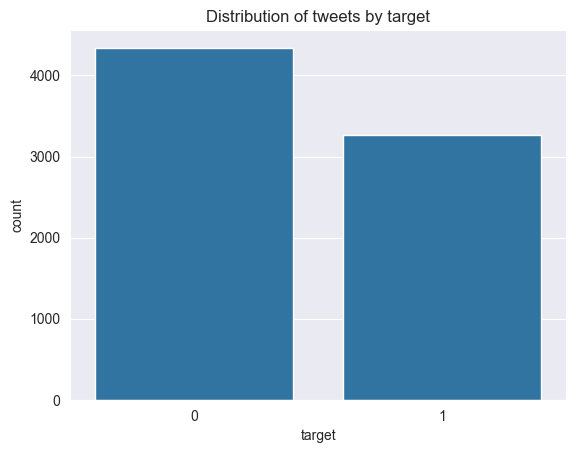

In [8]:
#Checking if the target is balanced
sns.countplot(data = train, x = "target")
plt.title("Distribution of tweets by target")
plt.ylabel("count")
plt.xlabel("target")
plt.show()

We can see a moderate class imbalance between disaster (1) and non-disaster (0) tweets. This explains why some models struggle with recall for class 1.

I'll explore techniques like:
- Class weighting (e.g. in LogisticRegression or RandomForest)
- Model selection (e.g. XGBoost handles imbalance well)


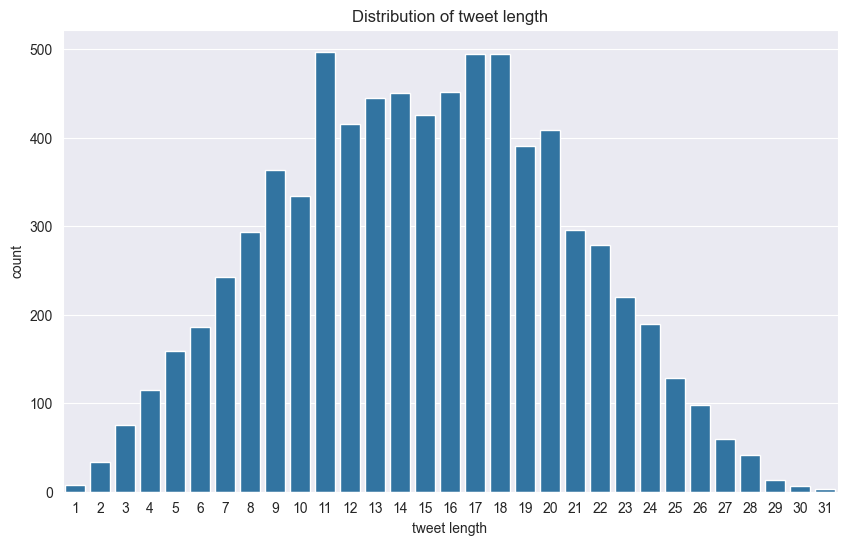

In [9]:
#Checking word length of tweets
train["tweet_length"] = train["text"].apply(lambda x: len(x.split()))

plt.figure(figsize = (10, 6))
sns.countplot(data = train, x = "tweet_length")
plt.title("Distribution of tweet length")
plt.ylabel("count")
plt.xlabel("tweet length")
plt.show()

### Data preprocessing

In [10]:
#Importing preprocessing libraries
import nltk

In [11]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Error loading stopwords: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1006)>
[nltk_data] Error loading punkt: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1006)>
[nltk_data] Error loading wordnet: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1006)>


False

In [12]:
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

import html


In [14]:
#Create a pipeline for data preprocessing

#Define stop words
stop_words = set(stopwords.words("english"))
custom_stopwords = {'via', 'like', 'people'}

#Defining lemmatizer
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    #Lowercase the text
    text = text.lower()

    #Remove URLs, mentions, hashtags and HTML tags
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)
    text = re.sub(r"<.*?>", '', text)
    text = re.sub(r"#", '', text)
    text = re.sub(r"@\w+", '', text)
    text = html.unescape(text)

    #Remove punctuation and numbers
    text = re.sub(r"[^a-z\s]", '', text)

    #Tokenize the text
    tokens = word_tokenize(text)

    #Remove stopwords
    tokens = [word for word in tokens if word not in stop_words]
    tokens = [t for t in tokens if t not in custom_stopwords]

    #Remove single letter words
    tokens = [t for t in tokens if len(t) > 1]

    #Lemmatize the tokens
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    #Join tokens back into string
    cleaned_text = " ".join(tokens)

    return cleaned_text

In [15]:
#Running the function to clean the text
train["clean_text"] = train["text"].apply(clean_text)

In [16]:
#Printing result
print(train["clean_text"][4])

got sent photo ruby alaska smoke wildfire pours school


In [17]:
#Printing original
print(train["text"][4])

Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school 


At first glance, the preprocessing seems effective. Retaining context whilst simplifying the text.

I will explore the top words in each class to get a better understanding.

In [18]:
from collections import Counter

In [19]:
#Creating a list of classes
disaster_tweet = train[train["target"] == 1]["clean_text"]
no_disaster_tweet = train[train["target"] == 0]["clean_text"]

In [20]:
#Checking the list
disaster_tweet

0       deed reason earthquake may...
1       forest fire near la ronge ...
2       resident asked shelter pla...
3       receive wildfire evacuatio...
4       got sent photo ruby alaska...
                    ...              
7608    two giant crane holding br...
7609    control wild fire californ...
7610             utckm volcano hawaii
7611    police investigating ebike...
7612    latest home razed northern...
Name: clean_text, Length: 3271, dtype: object

In [21]:
#Tokenizing the words to be counted
disaster_tweet_text = " ".join(disaster_tweet.astype(str))
disaster_words = word_tokenize(disaster_tweet_text)
disaster_word_counts = Counter(disaster_words)

no_disaster_tweet_text = " ".join(no_disaster_tweet.astype(str))
no_disaster_words = word_tokenize(no_disaster_tweet_text)
no_disaster_word_counts = Counter(no_disaster_words)

In [22]:
#Creating a df for class 1
disaster_top_words = disaster_word_counts.most_common(15)
disaster_df = pd.DataFrame(disaster_top_words, columns = ["word", "frequency"])
print(disaster_df.head())

         word  frequency
0        fire        265
1        news        138
2    disaster        119
3  california        115
4     suicide        110


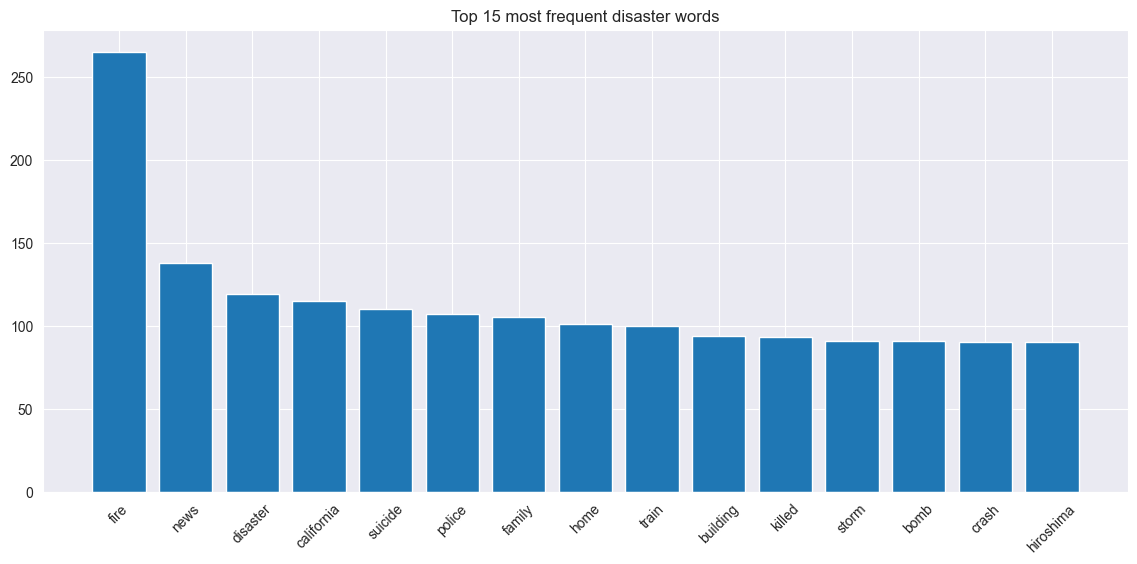

In [23]:
plt.figure(figsize = (14, 6))
plt.bar(disaster_df["word"], disaster_df["frequency"])
plt.title("Top 15 most frequent disaster words")
plt.xticks(rotation = 45)
plt.show()

In [24]:
#Creating a df for class 0
no_disaster_top_words = no_disaster_word_counts.most_common(15)
no_disaster_df = pd.DataFrame(no_disaster_top_words, columns = ["word", "frequency"])
print(no_disaster_df.head())

   word  frequency
0    im        248
1   get        185
2   new        170
3  dont        154
4   one        136


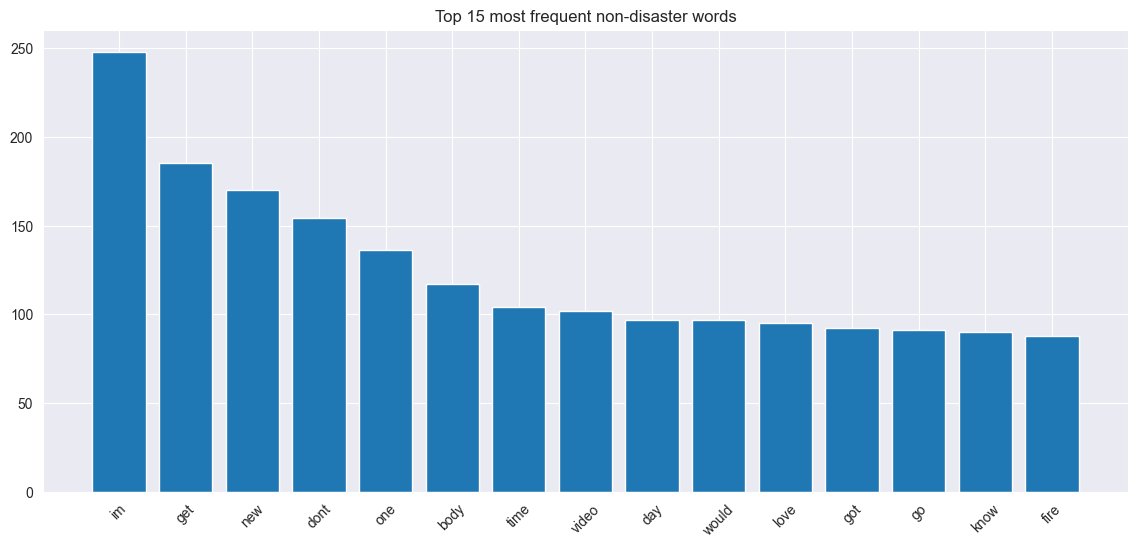

In [25]:
plt.figure(figsize = (14, 6))
plt.bar(no_disaster_df["word"], no_disaster_df["frequency"])
plt.title("Top 15 most frequent non-disaster words")
plt.xticks(rotation = 45)
plt.show()

Disaster-class tweets are dominated by high-alert tokens like *"fire"*, *"suicide"*, and *"police"*. In contrast, non-disaster tweets contain more casual language like *"like"*, *"im"*, and *"video"*.

This distinction supports our decision to apply TF-IDF, which downweights common terms and amplifies discriminative tokens.


### Text vectorization

In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [27]:
#Initialize the vectorizer
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))

In [28]:
#Fit and transform
X = vectorizer.fit_transform(train["clean_text"])

In [29]:
#Defining the target
y = train["target"]

In [30]:
print(X.shape)
print(vectorizer.get_feature_names_out()[:10])

(7613, 5000)
['aba' 'aba woman' 'abandoned' 'abandoned aircraft' 'abbswinston'
 'abbswinston zionist' 'abc' 'abc news' 'ability' 'ablaze']


In [31]:
X_cleaned_df = pd.DataFrame(X.toarray(),
                            columns = vectorizer.get_feature_names_out())

In [32]:
print(X_cleaned_df.head())

   aba  aba woman  abandoned  abandoned aircraft  abbswinston  abbswinston zionist  abc  abc news  ability  ablaze  able  abortion  absolutely  abstorm  \
0  0.0        0.0        0.0                 0.0          0.0                  0.0  0.0       0.0      0.0     0.0   0.0       0.0         0.0      0.0   
1  0.0        0.0        0.0                 0.0          0.0                  0.0  0.0       0.0      0.0     0.0   0.0       0.0         0.0      0.0   
2  0.0        0.0        0.0                 0.0          0.0                  0.0  0.0       0.0      0.0     0.0   0.0       0.0         0.0      0.0   
3  0.0        0.0        0.0                 0.0          0.0                  0.0  0.0       0.0      0.0     0.0   0.0       0.0         0.0      0.0   
4  0.0        0.0        0.0                 0.0          0.0                  0.0  0.0       0.0      0.0     0.0   0.0       0.0         0.0      0.0   

   abuse  access  access secret  accident  accident expert  accident 

### Baseline model

In [33]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

In [34]:
#Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Initialize the model with balanced class
model = LogisticRegression(max_iter=1000, class_weight="balanced")

#Fit the model
model.fit(X_train, y_train)

#Predict
y_pred = model.predict(X_test)

#Evaluate
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.81      0.81       874
           1       0.75      0.75      0.75       649

    accuracy                           0.79      1523
   macro avg       0.78      0.78      0.78      1523
weighted avg       0.79      0.79      0.79      1523



In [35]:
from sklearn.model_selection import GridSearchCV

In [36]:
#Defining parameters for grid search
logistic_params = {
    "C": [0.001, 0.01, 0.1, 1, 10, 100],
    "solver": ["liblinear", "saga"],
}

In [37]:
#Initializing grid search
logistic_grid = GridSearchCV(
    estimator=model,
    param_grid=logistic_params,
    cv=3,
    n_jobs=-1,
    verbose=0,
    scoring="accuracy"
)

In [38]:
#Fit
logistic_grid.fit(X_train, y_train)

,estimator,LogisticRegre...max_iter=1000)
,param_grid,"{'C': [0.001, 0.01, ...], 'solver': ['liblinear', 'saga']}"
,scoring,'accuracy'
,n_jobs,-1
,refit,True
,cv,3
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,penalty,'l2'


In [39]:
#Predict
y_pred_logistic = logistic_grid.best_estimator_.predict(X_test)

In [40]:
#Evaluate
print(classification_report(y_test, y_pred_logistic))

              precision    recall  f1-score   support

           0       0.81      0.84      0.82       874
           1       0.77      0.73      0.75       649

    accuracy                           0.79      1523
   macro avg       0.79      0.78      0.79      1523
weighted avg       0.79      0.79      0.79      1523



In [41]:
cm = confusion_matrix(y_test, y_pred_logistic)

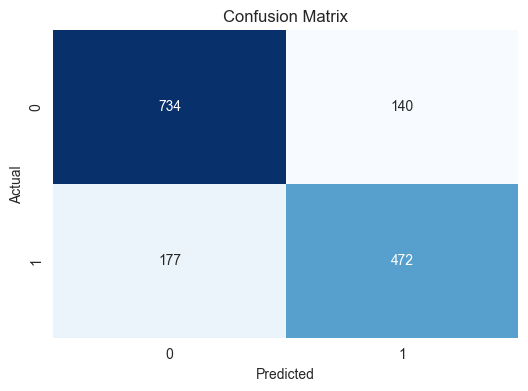

In [42]:
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.xticks([0.5, 1.5], ["0", "1"])
plt.yticks([0.5, 1.5], ["0", "1"])
plt.title("Confusion Matrix")
plt.show()

At 79% weighted average, the Logistic Regression models are working well in categorizing the tweets. The evaluation metrics suggest it is having more trouble categorizing disaster over no-disaster.

There are a high number of false-positives and false-negatives, showing the model can be improved.

### Naive Bayes

In [43]:
from sklearn.naive_bayes import MultinomialNB

In [44]:
#Initialize
nb_model = MultinomialNB()

#Fit
nb_model.fit(X_train, y_train)

#Predict
y_pred_nb = nb_model.predict(X_test)

#Evaluate
print(classification_report(y_test, y_pred_nb))

              precision    recall  f1-score   support

           0       0.79      0.90      0.84       874
           1       0.83      0.67      0.74       649

    accuracy                           0.80      1523
   macro avg       0.81      0.79      0.79      1523
weighted avg       0.81      0.80      0.80      1523



In [45]:
#Creating confusion matrix to evaluate positive and negative predictions
cm_nb = confusion_matrix(y_test, y_pred_nb)

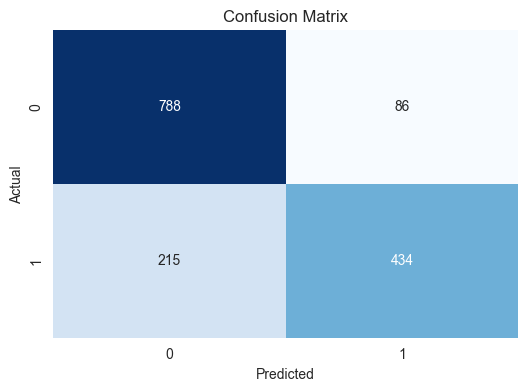

In [46]:
#Plotting confusion matrix
plt.figure(figsize=(6,4))
sns.heatmap(cm_nb, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.xticks([0.5, 1.5], ["0", "1"])
plt.yticks([0.5, 1.5], ["0", "1"])
plt.title("Confusion Matrix")
plt.show()

This model is doing well in predicting true-negatives but is struggling with positives, potentially due to class imbalances.

In [47]:
#Define params
nb_params = {"alpha": [0.001, 0.01, 0.1, 1, 10, 100]}

In [48]:
#Set up grid search
nb_grid = GridSearchCV(
    estimator=nb_model,
    param_grid=nb_params,
    cv=3,
    n_jobs=-1,
    verbose=0,
    scoring="accuracy"
)

In [49]:
#Fitting to training data
nb_grid.fit(X_train, y_train)

,estimator,MultinomialNB()
,param_grid,"{'alpha': [0.001, 0.01, ...]}"
,scoring,'accuracy'
,n_jobs,-1
,refit,True
,cv,3
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,alpha,1


In [50]:
#Predict
y_pred_nb_gs = nb_grid.best_estimator_.predict(X_test)

#Evaluate
print(classification_report(y_test, y_pred_nb_gs))

              precision    recall  f1-score   support

           0       0.79      0.90      0.84       874
           1       0.83      0.67      0.74       649

    accuracy                           0.80      1523
   macro avg       0.81      0.79      0.79      1523
weighted avg       0.81      0.80      0.80      1523



No improvement after GridSearch. Naive Bayes does not have a built-in class balancing function. This model limitation is shown in the recall score for class 1.

### Random forest

In [51]:
from sklearn.ensemble import RandomForestClassifier

In [52]:
#Initialize basic hyperparameters
model_rf = RandomForestClassifier(
    class_weight="balanced",
    n_estimators=100,
    random_state=42,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features="sqrt",
    n_jobs=-1
)

In [53]:
#Fit model
model_rf.fit(X_train, y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [54]:
#Predict
y_pred_rf = model_rf.predict(X_test)

In [55]:
#Evaluate
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.77      0.83      0.80       874
           1       0.74      0.67      0.71       649

    accuracy                           0.76      1523
   macro avg       0.76      0.75      0.75      1523
weighted avg       0.76      0.76      0.76      1523



The first basic random forest performed at a lower rate to the baseline model. I will now apply some hyperparameter tuning to improve the model performance.

In [56]:
#Defining the base model
rf_base = RandomForestClassifier(random_state=42, n_jobs=-1)

In [57]:
#Creating parameters
rf_params = {
    "n_estimators": [100, 200, 300, 400, 500],
    "max_depth": [1, 2, 3, 4, 5, 6, None],
    "min_samples_split": [2, 3, 4, 5, 6],
    "min_samples_leaf": [1, 2, 3, 4, 5, 6],
    "max_features": ["sqrt", "log2"],
    "class_weight": ["balanced"]
}

In [58]:
#Set up grid search
rf_grid = GridSearchCV(
    estimator=rf_base,
    param_grid=rf_params,
    cv=3,
    n_jobs=-1,
    scoring="accuracy",
    verbose=0
)

In [59]:
#Fitting grid search
rf_grid.fit(X_train, y_train)

,estimator,RandomForestC...ndom_state=42)
,param_grid,"{'class_weight': ['balanced'], 'max_depth': [1, 2, ...], 'max_features': ['sqrt', 'log2'], 'min_samples_leaf': [1, 2, ...], ...}"
,scoring,'accuracy'
,n_jobs,-1
,refit,True
,cv,3
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_estimators,100


In [60]:
#Predict
y_pred_rf_gs = rf_grid.best_estimator_.predict(X_test)

In [61]:
#Evaluate
print(classification_report(y_test, y_pred_rf_gs))

              precision    recall  f1-score   support

           0       0.80      0.87      0.83       874
           1       0.80      0.71      0.75       649

    accuracy                           0.80      1523
   macro avg       0.80      0.79      0.79      1523
weighted avg       0.80      0.80      0.80      1523



In [62]:
#Validating with confusion matrix
cm_rf = confusion_matrix(y_test, y_pred_rf_gs)

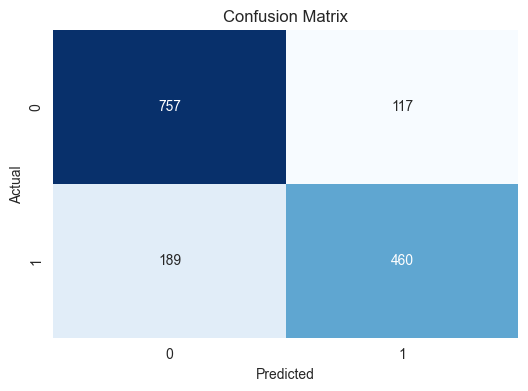

In [63]:
#Plotting confusion matrix
plt.figure(figsize=(6,4))
sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.xticks([0.5, 1.5], ["0", "1"])
plt.yticks([0.5, 1.5], ["0", "1"])
plt.title("Confusion Matrix")
plt.show()

Logistic Regression and Random Forest is delivering the best results, however, all models are struggling with class 1 recall.

I will try now with XGBoost because it may be able to better learn subtle patterns in class 1, whilst also dealing with class-inbalance.

| Model                | Accuracy | Class 1 Recall | Class 1 F1 |
|---------------------|----------|----------------|------------|
| Logistic Regression | 0.79     | 0.73           | 0.76       |
| Naive Bayes         | 0.79     | 0.67           | 0.74       |
| Random Forest       | 0.80     | 0.71           | 0.75       |

Class 1 remains the most difficult to predict accurately. Models tend to favour precision for class 1 over recall, suggesting some disaster tweets are misclassified as non-disasters.


### XGBoost

In [64]:
from xgboost import XGBClassifier

In [65]:
#Initialize model
model_xgb = XGBClassifier(scale_pos_weight=1.5, eval_metric='logloss', use_label_encoder=False, random_state=42)

#Fit
model_xgb.fit(X_train, y_train)

#Predict
y_pred_xgb = model_xgb.predict(X_test)

#Evaluate
print(classification_report(y_test, y_pred_xgb))

              precision    recall  f1-score   support

           0       0.78      0.83      0.81       874
           1       0.75      0.69      0.72       649

    accuracy                           0.77      1523
   macro avg       0.77      0.76      0.76      1523
weighted avg       0.77      0.77      0.77      1523



In [66]:
#Defining xgboost params
xg_params = {"n_estimators": [100, 200, 300, 400, 500],
             "max_depth": [1, 2, 3, 4, 5, 6],
             "learning_rate": [0.1, 0.2, 0.3, 0.4, 0.5],
             "subsample": [0.5, 0.6, 0.7, 0.8, 0.9],
             "colsample_bytree": [0.5, 0.6, 0.7, 0.8, 0.9],
             "reg_alpha": [0.1, 0.2, 0.3, 0.4, 0.5],
             "min_child_weight": [0.1, 0.2, 0.3, 0.4, 0.5],
             "objective": ["binary:logistic"]
             }

In [67]:
#Initializing grid search
xg_grid = GridSearchCV(estimator=model_xgb,
                       param_grid=xg_params,
                       cv=3,
                       n_jobs=-1,
                       scoring="accuracy",
                       verbose=0
                       )

In [68]:
#Fit
xg_grid.fit(X_train, y_train)

,estimator,"XGBClassifier...ree=None, ...)"
,param_grid,"{'colsample_bytree': [0.5, 0.6, ...], 'learning_rate': [0.1, 0.2, ...], 'max_depth': [1, 2, ...], 'min_child_weight': [0.1, 0.2, ...], ...}"
,scoring,'accuracy'
,n_jobs,-1
,refit,True
,cv,3
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,objective,'binary:logistic'


In [69]:
#Predict
y_pred_xgb_gs = xg_grid.predict(X_test)

In [70]:
#Evaluate
print(classification_report(y_test, y_pred_xgb_gs))

              precision    recall  f1-score   support

           0       0.79      0.80      0.80       874
           1       0.73      0.72      0.72       649

    accuracy                           0.77      1523
   macro avg       0.76      0.76      0.76      1523
weighted avg       0.77      0.77      0.77      1523



In [71]:
cm_xgb = confusion_matrix(y_test, y_pred_xgb_gs)

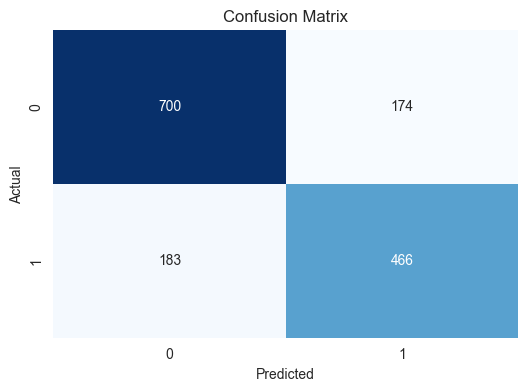

In [72]:
#Plotting confusion matrix
plt.figure(figsize=(6,4))
sns.heatmap(cm_xgb, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.xticks([0.5, 1.5], ["0", "1"])
plt.yticks([0.5, 1.5], ["0", "1"])
plt.title("Confusion Matrix")
plt.show()

### Model Summary and Conclusions

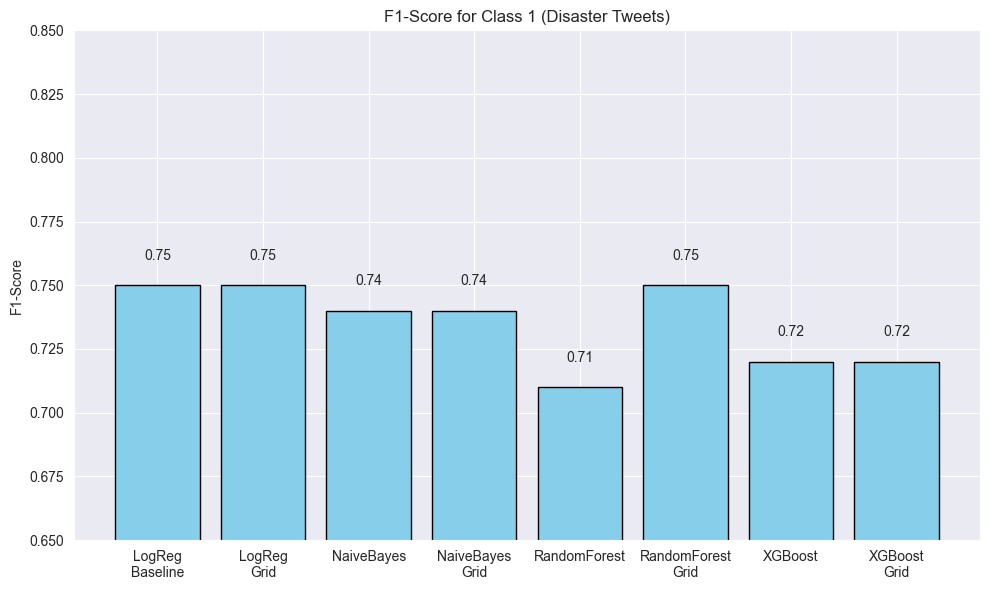

In [98]:
#F1-scores for class 1 (disaster) from your results
models = [
    "LogReg\nBaseline",
    "LogReg\nGrid",
    "NaiveBayes",
    "NaiveBayes\nGrid",
    "RandomForest",
    "RandomForest\nGrid",
    "XGBoost",
    "XGBoost\nGrid"
]

f1_scores_class1 = [0.75, 0.75, 0.74, 0.74, 0.71, 0.75, 0.72, 0.72]

#Plot
plt.figure(figsize=(10, 6))
bars = plt.bar(models, f1_scores_class1, color="skyblue", edgecolor="black")

#Highlight the best model
best_index = f1_scores_class1.index(max(f1_scores_class1))

#Add score labels
for i, score in enumerate(f1_scores_class1):
    plt.text(i, score + 0.01, f"{score:.2f}", ha='center', fontsize=10)

plt.title("F1-Score for Class 1 (Disaster Tweets)")
plt.ylabel("F1-Score")
plt.ylim(0.65, 0.85)

plt.tight_layout()
plt.show()


- Preprocessing and TF-IDF vectorization significantly impacted model performance.
- Random Forest and Logistic Regression yielded the best results.
- Class 1 (disaster) prediction remains challenging, due to subtle or ambiguous language.

**Next steps could include:**
- Training on BERT embeddings or other transformer-based NLP models.
- Adding tweet metadata (e.g. location, user, time) if available.
- Ensemble learning or stacking classifiers.